In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import chart_studio.plotly as py
import numpy as np
import datetime as datetime
from datetime import date, timedelta
import requests
import io
import folium
from folium import Circle
import warnings

In [42]:
# We define a function to get the raw data from the corresponding url and retruning it as a dataframe.
# <br>This function allows us to get the latest updates.

In [43]:
def get_raw_data(url):
    req = requests.get(url).content
    return pd.read_csv(io.StringIO(req.decode('utf-8')))

# Worldwide Analysis

## Data cleaning and first observations

Import the latest reports from CSSE at Johns Hopkins University.
The datasets we will use are:
1. da_world: Worldwide data (time series).
2. da_confirmed_w: Number of confirmed cases per country (time series).
3. da_fatalities_w: Number of deaths per country (time series).
4. da_recovered_w: Number of recovered cases per country (time series).

<br> Date of the latest data to be gathered is "yesterday" to ensure the data is available as the files are updated daily at midnight.
<br> We use the date variable "yesterday" to build the urls dynamically.

In [44]:
yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.strftime("%m-%d-%Y") 

In [45]:
world_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv".format(yesterday)
confirmed_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
fatalities_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_w_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
da_world = get_raw_data(world_url)
da_confirmed_w = get_raw_data(confirmed_w_url)
da_fatalities_w = get_raw_data(fatalities_w_url)
da_recovered_w = get_raw_data(recovered_w_url)

First look at the overall data. 

In [46]:
da_world.head().style.hide_index()

FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
45001.000000,Abbeville,South Carolina,US,2020-04-01 21:58:49,34.223334,-82.461707,4,0,0,0,"Abbeville, South Carolina, US"
22001.000000,Acadia,Louisiana,US,2020-04-01 21:58:49,30.295065,-92.414197,47,1,0,0,"Acadia, Louisiana, US"
51001.000000,Accomack,Virginia,US,2020-04-01 21:58:49,37.767072,-75.632346,7,0,0,0,"Accomack, Virginia, US"
16001.000000,Ada,Idaho,US,2020-04-01 21:58:49,43.452658,-116.241552,195,3,0,0,"Ada, Idaho, US"
19001.000000,Adair,Iowa,US,2020-04-01 21:58:49,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"


We rename the columns to the values originally used in this notebook as the column names from the sources have been changing over time.

In [47]:
da_world = da_world.rename(columns={"Country_Region": "Country/Region", "Lat":"Latitude", "Long_":"Longitude"})

We clean up the data and consolidate the names of countries with several variations or with a comma using the function format_country. 
<br>From the first look at the datasets, we found that South Korea is Korea,South in the original dataset and Congo is assigned for both the "Republic of the Congo" and the "Democratic Republic of the Congo" . 

In [48]:
#da_world[da_world["Country/Region"].str.contains("Korea")]

In [49]:
#da_world[da_world["Country/Region"].str.contains("Congo")]

In [50]:
def format_country(da, original, new):
    list_change = da[da["Country/Region"].str.contains(original)].index
    for x in list_change:
        da.loc[x,"Country/Region"] = new
        if "Combined_Key" in da:
            da.loc[x,"Combined_Key"] = new
    return da

In [51]:
datasets = [da_world, da_confirmed_w, da_fatalities_w, da_recovered_w]
countries_to_format = ["Korea","Brazzaville","Kinshasa"]
formatted_countries = ["South Korea", "Republic of the Congo","Democratic Republic of the Congo"]
for c in range(len(countries_to_format)):
    for x in range(len(datasets)):
        format_country(datasets[x],countries_to_format[c],formatted_countries[c])
        #print(datasets[x][datasets[x]["Country/Region"].str.contains(formatted_countries[c])]["Country/Region"])

We add a column for the active positive cases. 
<br>Our main interest is to see how the numbers of active cases are changing. 
<br> Note: This column wasn't available in the original dataset when this notebook started to take shape.



In [52]:
da_world["Active"] = da_world["Confirmed"] - da_world["Recovered"] - da_world["Deaths"]

In [53]:
#da_world.head().style.hide_index()

## Global numbers in a nutshell

In [54]:
total_w = da_world[["Confirmed","Active","Recovered","Deaths"]].sum()
print(total_w.to_string())

Confirmed    932605
Active       692619
Recovered    193177
Deaths        46809


We group the dataset by countries to have a total value per nation and list the top five countries with active cases. 

In [72]:
total_countries = da_world.groupby("Country/Region")[["Confirmed","Active","Recovered","Deaths"]].sum(
              ).sort_values(by="Active",ascending=False)
#total_countries.head()

In [73]:
total_all = total_countries
total_all = total_all.reset_index()
total_all.head().style.hide_index()

Country/Region,Confirmed,Active,Recovered,Deaths
US,213372,200141,8474,4757
Italy,110574,80572,16847,13155
Spain,104118,72084,22647,9387
Germany,77872,58252,18700,920
France,57749,42653,11053,4043


In [74]:
total_all["lat"]= np.nan
total_all["long"]= np.nan

In [75]:
#len(total_all)

In [76]:
places = total_all["Country/Region"]

In [77]:
#places

In [78]:
for x in range(len(places)-1):
    if not da_world[da_world["Country/Region"] == places[x]].empty:
        loc_country = da_world[da_world["Country/Region"] == places[x]][["Latitude","Longitude"]].to_numpy()
        if loc_country.shape != (1,2):
            a=0
            #print("country shape: ",places[x])
        else:
            total_all.loc[x,["lat"]] = loc_country[0,0]
            total_all.loc[x,["long"]] = loc_country[0,1]
    else:
        print("not found: ",places[x])

In [79]:
#total_all.head()

In [80]:
#total_all[~pd.notnull(total_all["lat"])]

We create a function to gather the latitude and longitude information for each country. Coordinates are added manually for those countries with nan values due to wrong shape of coordinates.

In [81]:
def add_coordinates(country,lat,long):
    total_all.loc[total_all["Country/Region"] == country,"lat"] = lat
    total_all.loc[total_all["Country/Region"] == country,"long"] = long
    return total_all

In [82]:
add_coordinates("US", 38.9072, -77.0369)
add_coordinates("France", 48.8566, 2.3522)
add_coordinates("United Kingdom", 51.5074, 0.1278)
add_coordinates("Netherlands", 52.3667, 4.8945)
add_coordinates("China", 35.8617, 104.1954)
add_coordinates("Canada", 45.4215, -75.6972)
add_coordinates("Australia", -33.8688, 151.2093)
add_coordinates("Denmark", 55.6761, 12.5683)
add_coordinates("Republic of the Congo", -0.2280, 15.8277)
add_coordinates("Syria", 34.8021, 38.9968)
add_coordinates("Saint Vincent and the Grenadines", 12.9843, -61.2872)
total_all.head().style.hide_index()

Country/Region,Confirmed,Active,Recovered,Deaths,lat,long
US,213372,200141,8474,4757,38.907200,-77.036900
Italy,110574,80572,16847,13155,41.871940,12.567380
Spain,104118,72084,22647,9387,40.463667,-3.749220
Germany,77872,58252,18700,920,51.165691,10.451526
France,57749,42653,11053,4043,48.856600,2.352200


We create a map where each country with active cases is labeled as follows:
<br>Blue circle: less than 1000 reported active cases.
<br>Orange circle: more than 1000 and less than 10000 reported active cases.
<br>Red circle: more than 10000 reported active cases.

In [83]:
world_map = folium.Map(location=[41.8719, -20], tiles='cartodbpositron', zoom_start=2.5)
def color_producer(val):
    if val < 1000:
        return 'blue'
    elif val < 10000:
        return 'orange'
    else:
        return 'red'

for i in range(0,len(places)):
    if not(np.isnan(total_all.iloc[i]['lat']) or np.isnan(
            total_all.iloc[i]['long'])):
        folium.Circle(       
        location=[total_all.iloc[i]['lat'], total_all.iloc[i]['long']],
        popup=("Country: " + str(places[i]) + "<br>"
               "Confirmed cases: " + str(total_all.iloc[i]["Confirmed"])+"<br>"
               "Active cases: " + str(total_all.iloc[i]["Active"])+"<br>"
               "Recovered: " + str(total_all.iloc[i]["Recovered"])+"<br>"
               "Deaths: " + str(total_all.iloc[i]["Deaths"])),
        radius=(total_all.iloc[i]['Active']*2000000)/total_all['Active'].sum(), 
        color=color_producer(total_all.iloc[i]['Active']),
        fill_color=color_producer(total_all.iloc[i]['Active']),
        title='Covid-19 active cases worldwide').add_to(world_map)

world_map

Summary data per country is shown if you click on each country's circle.

## Top 15 countries by number of active cases

We list the fifteen countries with most active cases.
<br> We also calculate the death rate vs confirmed positive cases and include it in the column "Death rate".

In [84]:
warnings.filterwarnings("ignore")
top_fifteen = total_all.head(15)
top_fifteen["Death rate [%]"] = round(100*top_fifteen["Deaths"]/ top_fifteen["Confirmed"],2)
top_fifteen

,Country/Region,Confirmed,Active,Recovered,Deaths,lat,long,Death rate [%]
0,US,213372,200141,8474,4757,38.907200,-77.036900,2.23
1,Italy,110574,80572,16847,13155,41.871940,12.567380,11.90
2,Spain,104118,72084,22647,9387,40.463667,-3.749220,9.02
3,Germany,77872,58252,18700,920,51.165691,10.451526,1.18
4,France,57749,42653,11053,4043,48.856600,2.352200,7.00
5,Iran,47593,29084,15473,3036,32.427908,53.688046,6.38
6,United Kingdom,29865,27329,179,2357,51.507400,0.127800,7.89
7,Turkey,15679,15069,333,277,38.963700,35.243300,1.77
8,Switzerland,17768,14313,2967,488,46.818200,8.227500,2.75
9,Netherlands,13696,12261,260,1175,52.366700,4.894500,8.58


The value of death rate can be interpreted from several perspective. 
<br>Italy has the hightest death rate and tests are done massively.
<br>As of 13.03.20, most of the victims Covid-19 positive in Italy were 70 years old and older [1](https://www.medrxiv.org/content/10.1101/2020.03.15.20036293v1.full.pdf).
<br>According to a study by the Leverhulme Centre for Demographic Science at the University of Oxford [1](https://www.medrxiv.org/content/10.1101/2020.03.15.20036293v1.full.pdf) and a publication in FAZ [2](https://m.faz.net/aktuell/wissen/geist-soziales/coronavirus-pandemie-warum-ist-es-in-italien-so-schlimm-16693408.html), some of the main reasons for Italy's high death rate are:
* Italy is the world's second oldest population after Japan with 23% of the population aged 65 years and older compared to 13.2% younger than 16 year old.
* Northern Italy, the area in Italy with most cases, is the industrial heart of the country with high pollution levels and there are many inhabitants suffering from respiratory problems. 
* Family is very important in Italy and the contact between generations is close, even if multigenerations are not living during the same roof, they live close by and see each other frequently.
* Hugs and kisses on the cheek are common when greeting people in Italy.
* The initial lockdown measures in the Northern provices caused a boomerang effect as it caused an exodus and many students from the North with family in the South travelled home, contributing to the spread of the virus.

In [85]:
fig = px.treemap(top_fifteen,
                 path=['Country/Region'],
                 values=top_fifteen['Active'],
                 title='Top 15 Countries with Active Cases: status {}'.format(yesterday),
                 hover_data=['Confirmed', 'Active', 'Recovered','Deaths','Death rate [%]'],
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

Summary data per country is shown if you point on each country's block.

## Time trends for top four countries by number cases

In [86]:
top_four = top_fifteen["Country/Region"][0:4]
#top_four

We check the length of the datasets for worldwide confimed, recovered and fatalities and group them by country to avoid several entries per country. 

In [87]:
#top_fifteen.head()

In [88]:
print("Length of worldwide confirmed cases table: {}".format(len(da_confirmed_w)))
print("Length of worldwide fatalities table: {}".format(len(da_fatalities_w)))
print("Length of worldwide recovered table: {}".format(len(da_recovered_w)))

Length of worldwide confirmed cases table: 256
Length of worldwide fatalities table: 256
Length of worldwide recovered table: 242


In [89]:
da_conf_grouped = da_confirmed_w.groupby("Country/Region")
da_fat_grouped = da_fatalities_w.groupby("Country/Region")
da_rec_grouped = da_recovered_w.groupby("Country/Region")
print("Length of unique country values for worldwide confirmed cases: {}".format(len(da_conf_grouped)))
print("Length of unique country values for worldwide fatalities: {}".format(len(da_fat_grouped)))
print("Length of unique country values for worldwide recovered: {}".format(len(da_rec_grouped)))

Length of unique country values for worldwide confirmed cases: 180
Length of unique country values for worldwide fatalities: 180
Length of unique country values for worldwide recovered: 180


In [90]:
def top_four_filter(da, top_four, status):
    da_filter = pd.DataFrame([da.get_group(x).drop(
                            ["Province/State", "Lat", "Long"], axis=1).sum() for x in top_four])
    
    for x in range(len(da_filter)):
        if "China" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="China"
        if "US" in da_filter.iloc[x,0]:
            da_filter.iloc[x,0]="US"
            
    da_filter["Country/Region"]=da_filter["Country/Region"] + " " +status
    return da_filter

China and South Korea are added to the list for comparison reasons as they have been the two first countries to slow down and decrease the number of active cases after an outbreak.

In [91]:
comparison_countries = pd.Series(["China","South Korea"])
top_four =top_four.append(comparison_countries, ignore_index=True)
#top_four

In [92]:
comparison_countries = pd.Series(["China","South Korea"])
top_four.append(comparison_countries)
top_four_all = top_four_filter(da_conf_grouped, top_four, "confirmed").append(
               top_four_filter(da_fat_grouped, top_four, "fatalities").append(
              top_four_filter(da_rec_grouped, top_four, "recovered")))

In [93]:
top_four_all = top_four_all.T
top_four_all.columns = top_four_all.iloc[0]
top_four_all = top_four_all.drop(top_four_all.index[0])
top_four_all = top_four_all.reset_index()
top_four_all = top_four_all.rename(columns={"index":"Date"})

In [94]:
#top_four_all.tail(5)

In [95]:
for x in top_four:
    top_four_all[x + " active"] = top_four_all[x+" confirmed"] - top_four_all[
        x+" recovered"] - top_four_all[x+" fatalities"]
#top_four_all.tail()

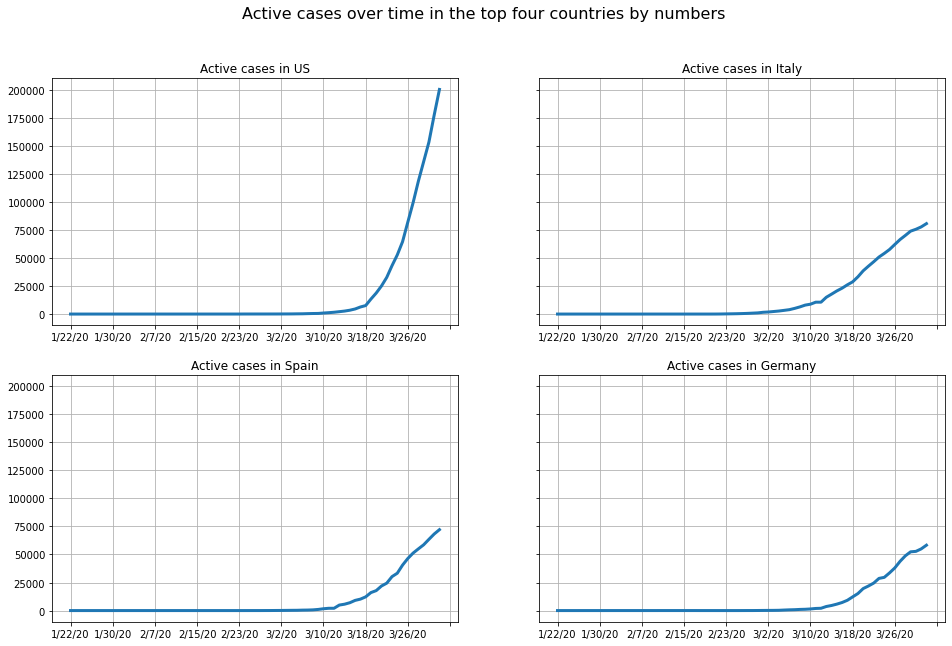

In [96]:
fig, ax = plt.subplots(2, 2, figsize=(16,10), sharey = True)

def plot_top4(da,num,xcol, ycol, title):
    ax[num].plot(da[xcol],da[ycol], lw=3)
    ax[num].set_title(title)
    ax[num].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[num].grid(True)
    
plot_top4(top_four_all, (0,0), "Date", top_four[0] + ' active', 'Active cases in {}'.format(top_four[0]))
plot_top4(top_four_all, (0,1), "Date", top_four[1] + ' active', 'Active cases in {}'.format(top_four[1]))
plot_top4(top_four_all, (1,0), "Date", top_four[2] + ' active', 'Active cases in {}'.format(top_four[2]))
plot_top4(top_four_all, (1,1), "Date", top_four[3] + ' active', 'Active cases in {}'.format(top_four[3]))
fig.suptitle('Active cases over time in the top four countries by numbers', fontsize=16)

plt.show()

As of 27.03, US has surpassed Italy in number of active cases and China in number of total positives. 
<br>US curve of active cases has grown dramatically in the last two weeks. 
<br>Italy started a strong growth of cases around the carnival festivities in the third week of February whereas Germany's and Spain's curves of active cases started to go up at a fast pace around two weeks after.
<br> As of 31.03, the growth of the active cases curves for Italy and Germany is showing signs of slowing down.
<br>Question: Why did the curve in US take momentum in such a short timeframe in comparison to Italy, Germany and Spain? Might it be related to the lack of early contigency measures and lack of initial testing? 
<br>As in many of the countries with most active cases, the most dense and international cities are the ones worst hit by the outbreak. In US, the biggest hub of cases is located in NYC. 

We compare the curves above with the one from China, the country with the most reported cases so far but with a declining number of new positive cases. 
<br> We added also the graph from South Korea where the active cases are starting to drop since mif March.
<br> In both countries the peak of active cases shows in the graphs around a month since the curve started to increase at a fast pace. 
<br>Both countries took strict measures to content the spread of the virus including lockdowns of hotspots, social distancing, self-isolation and closing of public places and schools. In addition, in South Korea, a massive testing campaign was done to identify and traces cases in the earlier stages and limit the spread. 

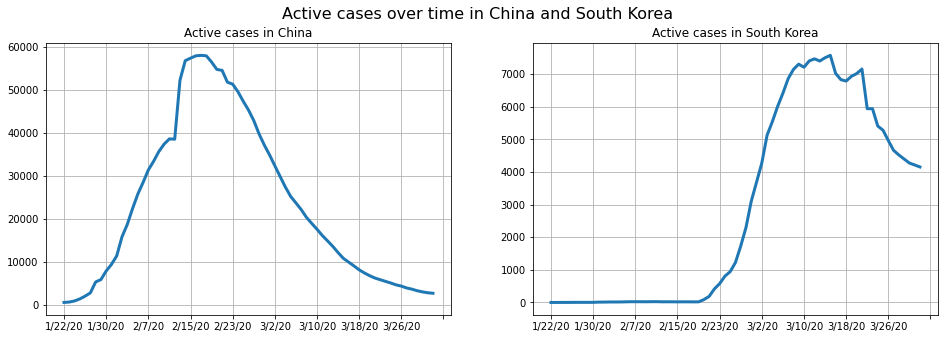

In [98]:
fig, ax = plt.subplots(1, 2, figsize = (16,5))
plot_top4(top_four_all, 0, "Date", 'China active', 'Active cases in China')
plot_top4(top_four_all, 1, "Date", 'South Korea active', 'Active cases in South Korea')
fig.suptitle('Active cases over time in China and South Korea', fontsize = 16)

plt.show()